# Causal Data Analysis

We have seen how to characterize the relationship between two or more variables with correlation and linear regression. We also said that **correlation is not causation**, meaning that, if we observe a correlation between two variables, that does not necessarily imply a cause-effect relationship between them. However, in many cases, it is still useful (or required!) to establish a cause-effect relationship (or lack thereof) between two variables. Consider the following examples:

* We assess that **a given disease is more frequent among smokers**. Is this just a correlation or is there a cause-effect relationship? If a smoker stops smoking, will their risk to get the disease be reduced?
* **We develop a new drug** and assess that people taking this drug are less likely to get disease X. Is this just a correlation or is there a cause-effect relationship? This is important, as people should take the drug only if benefits are clear.
* **A large company founds that product sites located in the geographical areas close to the sea are more productive than the others**. Is this just a correlation or is it a cause-effect relationship? Shall we move all sites closer to the sea?

Luckily, the field of **causal analysis** has, over the years, developed a set of tools which allow to answer those questions.

The goal of this lecture is to provide a primer of causal analysis, introducing the main concepts and discussing some techniques which can be applied in some simple cases.

## Sleep vs Exam Performance
We will consider a simple example which will guide us through the understanding of the main concepts of causal analysis. The data is made up and showing somewhat extreme correlations, but it should serve the purpose of illustrating the main concepts.

We want to study the relationship between sleep and exam performance (in a $0-100$ scale), so we asked $50$ students to tell us about their sleeping habits (in particular, we asked if they sleep, in average, 8 hours of more, the recommended number of hours for their age). We put these numbers together with the average exam performance of the students, obtaining the following data:

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Simulate data with a confounder (sleep duration)
np.random.seed(42)
num = 50
study_time = np.random.normal(6, 2, num)  # Mean study time of 5 hours with a standard deviation of 2 hours
sleep_duration = 14 - study_time*np.random.normal(1, 0.2, num) + np.random.normal(0, 1, num)  # Mean sleep duration of 7 hours with a standard deviation of 1.5 hours
exam_performance = 40 + 5 * study_time + np.random.normal(0, 10, num)  # Linear relationship with noise
exam_performance[exam_performance>100] = 100

# Create a DataFrame
students_all = pd.DataFrame({'Average Study Time': study_time, 'Average Sleep Duration': sleep_duration, 'Average Exam Performance': exam_performance})

students_all['Sleep 8 Hours or More'] = students_all['Average Sleep Duration']>=8
students_sleep = students_all.drop('Average Study Time',axis=1)
students_sleep = students_sleep.drop('Average Sleep Duration', axis=1)
students_sleep


,Average Exam Performance,Sleep 8 Hours or More
0,77.472070,False
1,72.081839,True
2,69.676638,False
3,87.552836,False
4,70.589191,False
5,60.515116,False
6,100.000000,True
7,82.412677,False
8,53.392221,True
9,81.991137,False


We want to understand if sleep has an effect on exam performance. Let us show some boxplots:

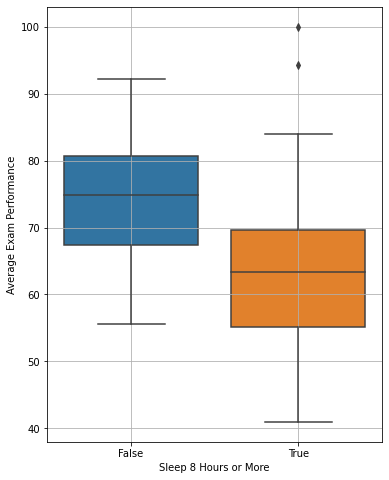

In [103]:
import seaborn as sns
plt.figure(figsize=(6,8))
sns.boxplot(x='Sleep 8 Hours or More', y='Average Exam Performance', data=students_sleep)
plt.grid()
plt.show()

We got a surprising picture! Sleeping $8$ hours or more, actually affects negatively the average exam performance! To check if everything is fine, we can add some "notch" to the boxplots. The notch will highlight the confidence intervals for the estimation of the median value:

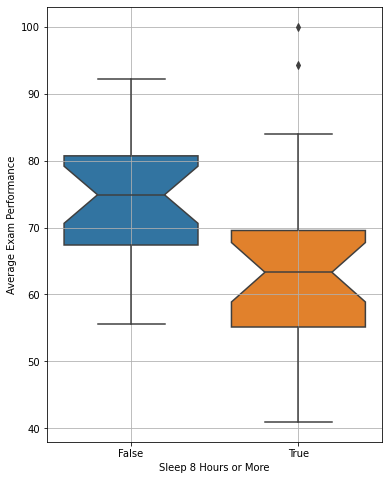

In [104]:
import seaborn as sns
plt.figure(figsize=(6,8))
sns.boxplot(x='Sleep 8 Hours or More', y='Average Exam Performance', data=students_sleep, notch=True)
plt.grid()
plt.show()

Since the notches do not intersect, there is no overlap between the confidence interval for a C.L. of $95$, hence it is very unlikely that the two median values are very close to each other. The difference seem to be statistically relevant. If we want to be very sure we can **compute a two-sample t-Test** to ensure that the mean values of the two samples actually are distinct. The null hypothesis will be that the two samples have the same mean. If we reject this hypothesis, then the two means are distinct. We obtain the following test statistic and p-value:

In [105]:
import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(students_sleep[students_sleep['Sleep 8 Hours or More']]['Average Exam Performance'], students_sleep[~students_sleep['Sleep 8 Hours or More']]['Average Exam Performance'])

print(f"Test statistic: {t_stat}")
print(f"P-value: {p_value}")


Test statistic: -2.5330249947772807
P-value: 0.014630790631265746


Also in this case, the difference seems to be statistically significant.

## Measuring Causation - Potential Outcomes (Counterfactuals)
We now start formulating hypotheses and theories: it looks counter-intuitive, but this is what the data is telling us. Isn't it? It might be that sleeping too much makes you less reactive in the morning, so you cannot properly focus and this makes you a worse student. 

If this is true, than we could "**prescribe**" students to sleep less than $8$ hours to obtain gains in performance. But we also know that... **correlation is not (necessarily) causation!**. We are seeing a correlation here - is it also causation? Of course, we want to be able to tell our students whether to sleep less or not!

To be able to truly assess a causal relationship between the two variables, ideally, we would like to **take the same student and ask them to sleep more than $8$ hours for one year, than less than $8$ hours for another years, then compare performance**. This is of course unethical and impractical. And even if we could do so, between the two years, different other factors may change, so the two values will never be fully comparable.

We will now **enter the realm of potential outcomes**. In practice, we ask ourselves questions such as **"what if this student slept less than $8$ hours?"**. Let's see some notation first. We will define two variables:

* $T_i$: a "treatment" value indicating whether the observation $i$ (student $i$) took the treatment (i.e., slept more than $8$ hours) or not. Here we use the standard terminology of causal inference which uses the word "treatment" as in health-related sciences. We will assume this variable to be binary: $T_i=1$ means "took the treatment", while $T_i=0$ means "didn't take the treatment".
* $Y_i$: the "outcome" of observation $i$. In our case, this is the average performance of student $i$.

If for a unit $i$, the treatment value is $T_i=t$, we will denote the related observation $Y_i$ as $Y_i(t)$. We note that, for a given unit $i$, we will **either observe $Y_i(0)$ or $Y_i(1)$, but never both!**.

Nevertheless, we will introduce the concept of **potential outcome** as the **value we would observe if we were able to intervene on the treatment variable $T_i$ and change it**. If for a unit $i$ we have $T_i=0$, we will directly observe the outcome $Y_i(0)$, but we will also **theoretically define** the potential outcome $Y_i(1)$. This **is not real and cannot be observed** but it will serve as a useful theoretical concept.

Potential outcomes are also known as **counterfactuals** because they answer to the question "what if...".

If we had potential outcomes, for each unit $i$ we could compute the **individual treatment effect** (the effect of taking the treatment) as:

$$Y_i(1) - Y_i(0)$$

This is the effect of sleeping less than $8$ hours. If we average this over the distribution of observations, we obtain the **average treatment effect**:

$$ATE = E[Y(1) - Y(0)]$$

This value will tell us **how the exam performance varies in average if the same subjects sleep less or more than $8$ hours**. As such, it would indicate **the causal effect of sleep on examination performance**.

Alternatively, we can compute the **average treatment effect on the treated**:

$$ATT = E[Y(1) - Y(0)|T=1]$$

This simply restricts the computation to the treated subjects, and **also establishes a causal effect**.

## The Bias Arising from Correlation

Without potential outcomes, we cannot compute the $ATE$ or $ATT$ scores. Indeed, we have **two distinct groups**, the **treated** (i.e., those observations $i$ such that $T_i=1$) and the **untreated**, also known as **control group** (i.e., those observations $i$ such that $T_i=0$).

We could think to replace that calculation with the only data we can observe:

$$E[Y(1)|T=1] - E[Y(0)|T=0]$$

This is what **a correlation can measure**: the change in average value of $Y$ in two distinct groups with different characteristics.

Note that there are no potential outcomes in the expression above as we directly observe $Y_i(1)$ when $T_i=1$ and we directly observe $Y_i(0)$ when $T_i=0$. However, the expression above is now **comparing different groups**. Indeed, the subjects who took the treatment are different from the ones who did not take the treatment, and we do not know if their exam performance scores are really comparable. **Imagine that, for some reason, students in group 0 are, by chance, better students, then the difference we measure is going to be biased and will not reveal a cause-effect relationship**.

We can show this in formulas. Let's add and subtract the counterfactual term $E[Y(0)|T=1]$ to the expression above:

$$E[Y(1)|T=1] - E[Y(0)|T=0] = E[Y(1)|T=1] - E[Y(0)|T=0] - E[Y(0)|T=1] + E[Y(0)|T=1]$$

We note that:

$$ATT = E[Y(1) - Y(0)|T=1] = E[Y(1)|T=1] - E[Y(0)|T=1]$$

Hence, we can see the expression above as follows:

$$E[Y(1)|T=1] - E[Y(0)|T=0] = E[Y(1)|T=1] - E[Y(0)|T=1] + E[Y(0)|T=1] - E[Y(0)|T=0] = $$
$$= ATT + E[Y(0)|T=1] - E[Y(0)|T=0]$$

We will call the last term the bias:

$$BIAS = E[Y(0)|T=1] - E[Y(0)|T=0]$$

So the whole expression can be seen as:

$$E[Y(1)|T=1] - E[Y(0)|T=0] = ATT + BIAS$$

which shows that the effect given by the correlation (left term) is **biased**. Note that the bias cannot be computed (it contains a counterfactual term), but we can interpret it as follows:

> The bias measures how the treated ($T=1$) and control ($T=0$) groups would differ if no one had taken the treatment.

In practice: 
* If the groups are similar to each other (e.g., treated and control group are mixed students with similar abilities), then the bias will be small or zero. Indeed, in this case, the difference in exam performance among the two groups if everybody sleeps less than $8$ hours should be same, as students have similar abilities.
* If the groups are dissimilar (e.g., control students are all better students), then the bias will be different from zero. Indeed, if students in the control group are "better students", if all sleep less than $8$ hours, students in the control group will perform better in average, but this has nothing to do with sleeping less or more or with cause-effect relationships among the observed variables.

Note that, given the observations above, we now know **when association allows to establish a cause-effect mechanism**. This happens when the bias is zero:

$$BIAS = E[Y(0)|T=1] - E[Y(0)|T=0] = 0$$

That is to say, when the difference between treated and untreated is zero (or at least very small).

Given this intuition, we now try to estimate the students' abilities by asking how many hours they study per day. We get the following data:

In [106]:
students_all.drop('Average Sleep Duration', axis=1)

,Average Study Time,Average Exam Performance,Sleep 8 Hours or More
0,6.993428,77.472070,False
1,5.723471,72.081839,True
2,7.295377,69.676638,False
3,9.046060,87.552836,False
4,5.531693,70.589191,False
5,5.531726,60.515116,False
6,9.158426,100.000000,True
7,7.534869,82.412677,False
8,5.061051,53.392221,True
9,7.085120,81.991137,False


**We cannot measure bias from this data because we do not have access to counterfactual observations**, but, now that we have access to a proxy for students' abilities, we can try to see if, in the two groups, abilities are equally distributed. Let's see this with a scatterplot:

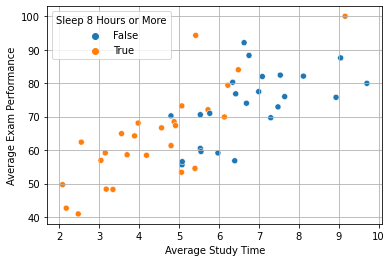

In [107]:
sns.scatterplot(x='Average Study Time', y='Average Exam Performance', data=students_all, hue='Sleep 8 Hours or More')
plt.grid()
plt.show()

From the picture above, we see that students' skills are not equally distributed in the two groups. This is not enough to say that the bias is different from zero, as we are not observing counterfactuals, but we now see that the difference in outcomes could be due to two different causes:
* Sleeping less than $8$ hours improves exam performance.
* Some of the difference may be due to the fact that students sleeping less than $8$ hours, incidentally, study more. This might be a sampling problem (we were lucky/unlucky) or an experiment design problem: students who sleep less have more time to study, so they have higher performance. If this is the case, it is not meaningful to look at hours of sleep to establish a cause-effect relationship.

Now that we have an intuition into what may make correlation be not indicative of causation, let's see how to reduce bias to establish cause-effect relationships.

## Randomized Controlled Trials (RCT)

We have seen that correlation is causation when the treated and control groups are comparable for everything except the treatment. The most robust method to remove this bias is via **randomized experiments**, or **Randomized Controlled Trials** (RCT).

A randomized experiment **randomly assigns individuals in a population to a treatment or a control group**. By performing a random assignment, we wish to make the two groups indistinguishable. Of course **one of the two groups will take the treatment and this will likely make the two groups distinguishable**, but we wish to make sure that, **apart from the treatment, the two groups are indeed indistinguishable**.

It can be shown that random assignment makes sure that the potential outcomes are conditionally independent given the treatment:

$$Y(0) \perp Y(1) | T$$

So, if the treatment $T$ is fixed, the potential outcomes are independent. For instance, if we fix $T=1$ (so we are taking subjects who sleep $8$ hours or more), then knowing the observed value $Y_i(1)$ (i.e., the observed exam performance of student $i$), does not tell me anything about the potential outcome $Y_i(1)$ (the exam performance that the same student would obtain if they slept less than $8$ hours).

If this conditional independence is valid, then:

$$E[Y(0)|T=0] = E[Y(0)|T=1] = E[Y(0)]$$

and:

$$E[Y(1)|T=0] = E[Y(1)|T=1] = E[Y(1)]$$

Which leads to:

$$E[Y(1)|T=1] - E[Y(0)|T=0] = E[Y(1)] - E[Y(0)] = E[Y(1)-Y(10)] = ATE$$

Hence, in this case, **correlation would be causation**.

### Example

Let us now consider an example. A school wants to see if a new teaching method is effective. To do so, they ask $50$ students if they want to **voluntarily enroll a tutoring program**. After one year, they measure the average performance of students who participated in the programme and compare it to those of students who did not participate in the programme. We obtain the following data:

In [108]:
np.random.seed(42)
n_students = 200
interest = np.random.uniform(1,5,n_students).round()
tutoring = (((interest-np.median(interest)) + np.random.normal(0,3,n_students))>0).astype(int)
performance = 30+2.5*(3*interest + np.random.normal(10,3,n_students) + 0.1*tutoring)
performance[performance<0] = 0
performance[performance>100] = 100

students1 = pd.DataFrame({
    'tutoring': tutoring,
    'performance' : performance
})

students3 = pd.DataFrame({
    'tutoring': tutoring,
    'performance' : performance,
    'interest': interest
})

students1

,tutoring,performance
0,0,76.432447
1,1,91.550461
2,1,85.107378
3,0,69.981030
4,1,70.111151
...,...,...
195,0,68.477160
196,0,87.783594
197,1,88.220111
198,1,93.399423


Let us visualize two boxplots:

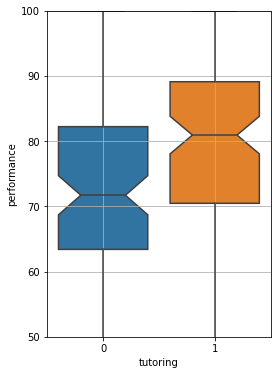

In [109]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(4,6))
sns.boxplot(x='tutoring', y='performance', data=students1, notch=True)
plt.grid()
plt.ylim([50,100])
plt.show()

It looks like a significant improvement. Let's check if this is statistically relevant with a two-sample t-test:

In [110]:
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(students1[students1['tutoring']==1]['performance'], students1[students1['tutoring']==0]['performance'])
print(f'T-test results - T-statistic: {t_stat}, p-value: {p_value}')

T-test results - T-statistic: 4.086568160195115, p-value: 6.358186591194311e-05


It looks like the tutoring program is a great success!

But, is it true? Well, we know that what we see is correlation, not necessarily causation. **What if there is some bias**?

We quickly realize that we did not perform a randomized experiment, because we did not randomly assigned students to one of the two groups. **What if only motivated students decided to enroll in the program and what if those students were the same who tend to study more than others?**

Let's say we could repeat the experiment, now with random assignment. **Word of caution**: this is not always possible. For instance, in this case, it would not be very polite to "force" students to enroll programs, so we may not be able to carry out this experiment, but let us assume for a moment that we can. 

We repeat the experiment and obtain these results:

In [111]:
np.random.seed(42)
n_students = 200
interest = np.random.uniform(1,5,n_students).round()
#tutoring = (((interest-np.median(interest)) + np.random.normal(0,3,n_students))>0).astype(int)
tutoring = ((np.random.normal(0,3,n_students))>0).astype(int)
performance = 30+2.5*(3*interest + np.random.normal(10,3,n_students) + 0.1*tutoring)
performance[performance<0] = 0
performance[performance>100] = 100

students2 = pd.DataFrame({
    'tutoring': tutoring,
    'performance' : performance
})
students2

,tutoring,performance
0,0,76.432447
1,1,91.550461
2,1,85.107378
3,0,69.981030
4,1,70.111151
...,...,...
195,0,68.477160
196,0,87.783594
197,0,87.970111
198,1,93.399423


Let's visualize the boxplots:

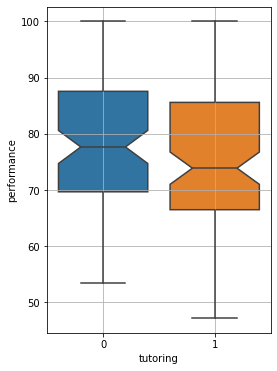

In [112]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(4,6))
sns.boxplot(x='tutoring', y='performance', data=students2, notch=True)
plt.grid()
plt.show()

We now see a less dramatic improvement. What happened?

By performing a random assignment, we got rid of selection bias. Students voluntarily choosing to enroll in the programme were probably more motivated and keen to study. We now see that the impact of tutoring is very small. We can perform a t-test to assess if this is statistically significant:

In [113]:
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(students2[students2['tutoring']==1]['performance'], students2[students2['tutoring']==0]['performance'])
print(f'T-test results - T-statistic: {t_stat}, p-value: {p_value}')

T-test results - T-statistic: -1.1327518742165317, p-value: 0.2586882978200426


We got a large p-value, the difference is not statistically significant.

## Causal Effect and Observational Studies
We have seen how to interpret an observed association as a cause-effect relationship we need to reduce bias. The gold standard is to use randomized controlled trials, however **this is not always feasible or ethical**. Consider for instance **the problem of estimating the effect of smoking on the development of a given disease**. To perform a randomized experiment, we should select subjects randomly in two groups and ask people in one of the two groups to smoke. **This is of course unethical, considering that we suspect that smoking has a bad effect on health**.

In these cases, we can only resort to **observational data**: we collect data of smokers and non-smokers and observe association in the data. However, we know that this process is **subject to bias**. How do we deal with it? In this part of the lecture, we will see that **graphical causal models** give us a framework to **set our believes on where bias come from**. If we can accurately model the source of bias, we can remove it by **controlling** on the variable "causing" the bias.

Let us consider our past example: students and tutoring. Let us assume that we cannot perform the random assignment (again, it's unethical!). Since we imagine that **the interest of students towards study can be a source of bias**, we now ask students to also tell us how interested they are in studying in general in a scale from $1$ to $5$. We obtain the following observations:

In [114]:
students3

,tutoring,performance,interest
0,0,76.432447,2.0
1,1,91.550461,5.0
2,1,85.107378,4.0
3,0,69.981030,3.0
4,1,70.111151,2.0
...,...,...,...
195,0,68.477160,2.0
196,0,87.783594,4.0
197,1,88.220111,5.0
198,1,93.399423,5.0


These are the same observations as the first case (before random assignment), but with an additional variable. We suspected that **interested students have an average higher performance and that interested students are more likely to enroll in the tutoring program**. Let us see graphically if this is true. If we split the data by interest and compute the boxplots of performance, we get the following graph:

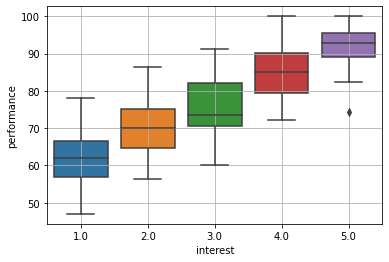

In [115]:
sns.boxplot(x='interest', y='performance', data=students3)
plt.grid()
plt.show()

We were right! (ok, this is an exaggerated picture, but this example is made up...)

Let us check how correlated are `interest` and `tutoring` with a barplot:

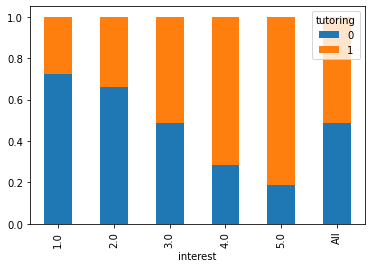

In [116]:
pd.crosstab(students3['interest'], students3['tutoring'], normalize=0, margins=True).plot.bar(stacked=True)
plt.show()


We can also check the distribution of interest in the two groups:

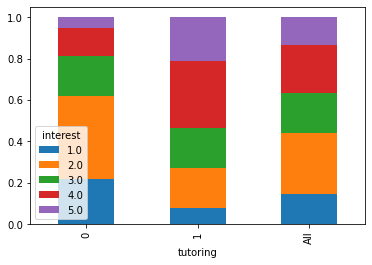

In [117]:
pd.crosstab(students3['interest'], students3['tutoring'], normalize=1, margins=True).T.plot.bar(stacked=True)
plt.show()

We can go ahead and compute a $\chi^2$ test of independence to check if the association between the two variables is statistically significant:

In [118]:
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association

contingency = pd.crosstab(students3['interest'], students3['tutoring'])

print(f"Chi-square statistic: {chi2_contingency(contingency).statistic:0.2f}")
print(f"Cramer V statistic: {association(contingency):0.2f}")
print(f"Chi-square p-value: {chi2_contingency(contingency).pvalue:e}")

Chi-square statistic: 31.22
Cramer V statistic: 0.40
Chi-square p-value: 2.761663e-06


We were right also in this case! Interest affects tutoring, hence interest is our source of bias!

The correlation between the `interest` variable and `tutoring` is making the "treated" (`tutoring=1`) and the "control" (`tutoring=0`) groups not comparable. Indeed, if people in the treated group have more chances of getting a higher response value (performance), then no wonder that we observe such dramatic differences among the two groups! In other words, **the effect we observe may be due to the bias introduced by `interest`, the effect of `tutoring`, or a combination of both**.

### Controlling for `interest`
How do we make the groups more comparable? Recall that we want:

$$Y(0) \perp Y(1) | T$$

We have seen that this is not true because of `interest`. Indeed, if we pick a person in the group $T=0$ with a high $Y(0)$, we can imagine this is due to a large value of `interest`, so we can easily predict that $Y(1)$ will also be large. **If we can predict $Y(1)$ from $Y(0)$, then they are not independent (conditioned on $T=1$ in this case)**.

To obtain the statement above, we should **perform a random assignment**, which we cannot do. However, we know that `interest` is the source of bias. Let us assume that it is the **only source of bias**. Then, if $X$ represents `interest`, we can say that:

$$Y(0) \perp Y(1) | T, X$$

**Indeed, if we pick a person from a group $T=0$ and with a given interest value $X=4$, then, given a large $Y(0)$ we cannot really say anything about $Y(1)$. Indeed, if $X=4$ and $Y(0)=80$, we have a student with great interest and high performance. What can we say about $Y(1)$? We could say that it will be high (the student has high interest), but any other student in this group will probably have a high score, so we cannot predict anything which will be significantly different from random (i.e., from the score of another random student within this group)**.

But, how do we condition on $X$? Well, the easiest way to do it, is to **divide the data into different groups based on the values of $X$ and assess any association within the groups**. Let us do it:

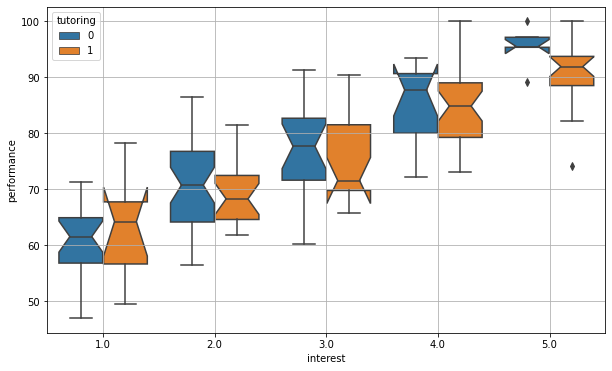

In [119]:
plt.figure(figsize=(10,6))
sns.boxplot(x='interest', y='performance', data=students3, notch=True, hue='tutoring')
plt.grid()
plt.show()

In the plot above, we compare the effect of tutoring in the different `interest` groups. As we can see, the association between `tutoring` and `performance` vanishes within the groups. This is shown by the fact that the notches (confidence intervals) tend to intersect. We can get a clearer picture by performing $5$ different two-sample statistical tests assessing whether the means of `performance` in the two groups differ in a statistically significant way:

In [120]:
ints = []
stats = []
pvals = []

for interest in students3['interest'].unique():
    #print(f"===== Interest: {int(interest)} =====")

    subset = students3[students3['interest']==interest]
    t_stat, p_value = ttest_ind(subset[subset['tutoring']==1]['performance'], subset[subset['tutoring']==0]['performance'])
    #print(f'T-statistic: {t_stat}, p-value: {p_value}')

    ints.append(interest)
    stats.append(t_stat)
    pvals.append(p_value)
    #print()

pd.DataFrame(dict(interest=ints, t_statistic=stats, p_value=pvals)).set_index('interest').sort_index()

,t_statistic,p_value
interest,,
1.0,0.934780,0.358187
2.0,-0.781177,0.437931
3.0,-0.867406,0.391310
4.0,0.164684,0.869947
5.0,-1.383074,0.178871


As we can see, there is no significant association between `performance` and `tutoring`, which suggests the lack of a causal effect.

**The act of conditioning on $X$ (e.g., by dividing into groups) is called "controlling for $X$"**.

## Graphical Causal Models
We have seen a simple case in which we could identify the main source of bias which was leading to an observed association not implying a cause-effect mechanism. However, not all cases are so simple and **more than one variable may be responsible for bias**. The question now is

> How do we identify the variables we should control for?

To help us in this quest, we can use graphical causal models. A graphical causal model is a **directed acyclic graph** formalizing cause-effect relationships between variables. **Each node is a random variable, while a directed edge $A \to B$ indicates that $A$ causes $B$.**

The causal graph describing the hypotheses we made in this example will look like this:

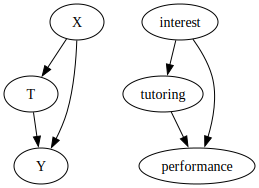

In [121]:
import graphviz as gr

g = gr.Digraph()
g.edge("X", "T")
g.edge("X", "Y")
g.edge("T", "Y")

g.edge("interest", "tutoring")
g.edge("interest", "performance")
g.edge("tutoring", "performance")

g

Indeed, we expect `interest` ($X$) to influence both `performance` ($Y$) and whether a subject belong to the treated or control group, i.e., the `tutoring` variable ($T$). From the model above, we can identify `interest` as a source of bias, but **as we will see shortly, we can use a set of rules to identify which variables we should control for or not control for from a graphical model**.

Before proceeding, a short note on **how graphical models are created**: these are generally designed by the data analyst who encodes their own **beliefs** on how the world works. These come from a "Bayesian" view of the world in which we first establish our beliefs and then use a theoretical framework to draw conclusions from them.

### Main Structures of Causal Graphical Models
Once we form a graphical model, we can identify a set of standard structures which will allow us to choose which variables to control for. We will see the main structures, but others beside the ones discussed here may exist.

#### Chains
The most straightforward structure is a chain of this kind:

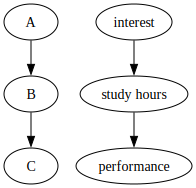

In [122]:
g = gr.Digraph()
g.edge("A", "B")
g.edge("B", "C")
g.node("B", "B")

g.edge("interest", "study hours")
g.edge("study hours", "performance")
g.node("study hours", "study hours")

g

The example above, `interest` in studying causes the number of `study hours`, which in turn causes `performance`. Let us imagine no other variable is involved (i.e., `interest` is the only variable causing `study hours` and `performance` is only caused by `study hours`). Then we will easily find that:

* `interest` and `study hours` will be associated;
* `study hours` and `performance` will be associated.
* `interest` and `performance` will be associated.

Indeed, for instance: 
* If a person has a great interest, then they will study a lot and have good performance;
* If a person has good performance, we can infer that it studies a lot and hence has great interest;
* If a person studies a lot, we infer that it has great interest and good performance;

Let say we **control for $B$, `study hours`**. We will denote the graph as follows (variable we are controlling for is in gray):

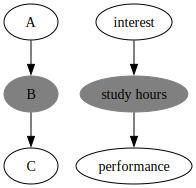

In [123]:
g = gr.Digraph()
g.edge("A", "B")
g.edge("B", "C")
g.node("B", "B", color='gray', style='filled')

g.edge("interest", "study hours")
g.edge("study hours", "performance")
g.node("study hours", "study hours", color='gray', style='filled')

g

If we **control for $B$, `study hours`, we will find that `interest` and `performance` are not associated anymore**. Indeed:

> If we consider a group of people who study the same amount of hours and I take a person with good performance, then I don't know if they have great interest or not. Or better, I cannot distinguish a person with great interest from a person with little interest as they all study the same amount of hours.

In mathematical terms, we know that in general:

$$A \not\perp C$$

but, by controlling for $B$, we obtain:

$$A \perp C | B$$

Hence, in groups with the same value of $B$, we will see an independence between $A$ and $B$.

In general, we say that **conditioning on $B$ blocks the dependency between $A$ and $C$**, hence **while there is a causal effect between $A$ and $C$, we cannot see it anymore when we condition on $B$**.

The graph below shows two identical graphs, except that we are conditioning on $B$ in the version on the right. Besides solid black arrows denoting cause-effect relationships, we also show **in red how dependency flows**.

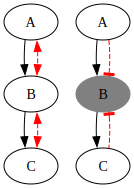

In [454]:
g = gr.Digraph()

g.node("A","A")
g.node("B","B")
g.node("C","C")
g.edge("A", "B")
g.edge("B", "C")
g.edge("A", "B", dir='both', color='red', style='dashed')
g.edge("B", "C", dir='both', color='red', style='dashed')


g.node("A2","A")
g.node("B2","B", color='gray', style='filled')
g.node("C2","C")
g.edge("A2", "B2")
g.edge("B2", "C2")
g.edge("A2", "B2",arrowhead='tee', color='red', style='dashed')
g.edge("B2", "C2", dir='back',arrowtail='tee',color='red', style='dashed')
g


* In the graph on the left, dependency flows in a bidirectional way **through variable $B$**. This means that $A$ depends on $B$ and $C$ and similarly $C$ depends on $B$ and $A$;
* In the graph on the right, conditioning on $B$ "stops" the dependency. Now:
  * $C$ and $A$ are independent of $B$. This makes sense because conditioning on $B$ means fixing a value for $B$, so $A$ and $C$ will be independent of the constant;
  * $A$ and $C$ are independent (we are conditioning on $B$, so we have $A \perp C | B$).

As a result, if we want to study the relation between $A$ and $C$, we **should not condition on B**, as this conditioning will make the association between $A$ and $C$ vanish, even if there is a causal effect between these variables.

We are encountering an important concept:

> Conditioning on **any** variable is not a good way to remove bias. If we condition on the "wrong" variable, we may introduce some bias which was not there in the first place and estimate the lack of a causal effect even in cases in which the causal effect is there.

### Forks
We have a fork structure when a variable causes two other variables. Let us see an example:

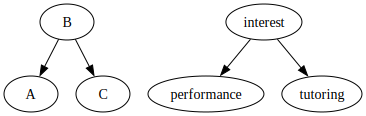

In [419]:
g = gr.Digraph()
g.edge("B", "A")
g.edge("B", "C")

g.node("B", "B")

g.edge("interest", "performance")
g.edge("interest", "tutoring")

g

In this case $B$ (`interest`) is causing both $A$ (`performance`) and $C$ (`tutoring`). This is the example we have seen before. In this case, as we have seen, we may see a correlation between `tutoring` and `performance`. Indeed, a large value of `performance` will probably mean that `interest` is high, hence `tutoring` will probably be equal to $1$.

> We will call $B$ (or `interest`) the **common cause**.

Although we will likely observe correlations between any pair of the $A$, $B$, and $C$ variables, we know from the graph that there is no cause-effect relationship between $A$ and $C$.

We say that the fork structure **creates a backdoor path such that dependence (or association) flows through $B$ (the backdoor) to go from $A$ to $C$**.

As we noted in the previous example, conditioning on $B$ (`interest`) makes the association between $A$ and $C$ vanish:

$$A \perp C | B$$

Hence in the following graph, we will observe no association between `performance` and `tutoring`, hence confirming the lack of a causal effect:

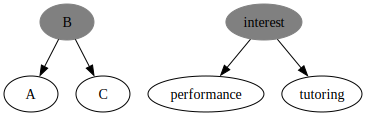

In [422]:
g = gr.Digraph()
g.edge("B", "A")
g.edge("B", "C")

g.node("B", "B", style='filled', color='gray')
g.node("interest", "interest", style='filled', color='gray')

g.edge("interest", "performance")
g.edge("interest", "tutoring")

g

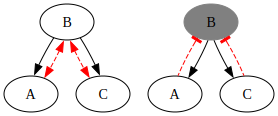

In [453]:
g = gr.Digraph()

g.node("A","A")
g.node("B","B")
g.node("C","C")

g.edge("B", "C", dir='both', color='red', style='dashed')
g.edge("B", "A")
g.edge("B", "C")
g.edge("B", "A", dir='both', color='red', style='dashed')

g.node("A2","A")
g.node("B2","B", color='gray', style='filled')
g.node("C2","C")

g.edge("B2", "A2",arrowtail='tee', dir='back', color='red', style='dashed')
g.edge("B2", "A2")
g.edge("B2", "C2")
g.edge("B2", "C2", dir='back',arrowtail='tee',color='red', style='dashed')

g


When we do not condition on $B$, dependency (hence association) flows from $A$ to $C$ through $B$. Hence, **we observe an association which is not due to a causal effect**.

When we condition on $B$, dependency (hence association) does not flow through $B$, so $A$ and $C$ will be independent and we will measure no association, as it should be.

### Colliders
The last, important structure, is a collider. This is in some sense the opposite of a fork: a variable is caused by two different variables. Let us see this with an example:

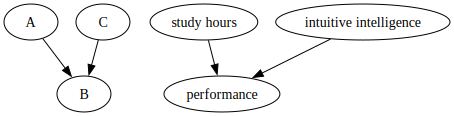

In [441]:
g = gr.Digraph()
g.edge("A", "B")
g.edge("C", "B")

g.node("B", "B")

g.edge("study hours", "performance")
g.edge("intuitive intelligence", "performance")

g

The graph above tells us that performance is caused by `study hours` and `intuitive intelligence`. We are making the assumption here that `intuitive intelligence` does not affect `study hours` in any way. This might be inaccurate, but we will anyway assume so for the sake of a simple example.

This structure is called a **collider**, because two arrows (from $A$ and $C$) collide on a single node ($B$).

A collider **blocks dependency**. This means that by default, if we do not condition on `performance`, we will observe no association between `study hours` and `intuitive intelligence`. Indeed:
* If we know that a person studies a lot, we cannot really say anything about their intuitive intelligence;
* If we know that a person has intuitive intelligence, we cannot say how much they study.

So, in the graph above:

$$A \perp C$$

Let us not consider a case in which we condition on $B$ (`performance`), as shown in the following graph:

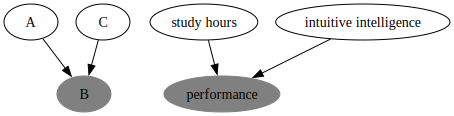

In [442]:
g = gr.Digraph()
g.edge("A", "B")
g.edge("C", "B")

g.node("B", "B", style='filled', color='gray')

g.edge("study hours", "performance")
g.edge("intuitive intelligence", "performance")

g.node("performance", "performance", style='filled', color='gray')

g

Conditioning on `performance` changes things. Indeed:
* If we know that a student has a **good performance** (i.e., we consider the group of good performing students when controlling), then **knowing that they do not study a lot, will tell us that they probably have good intuitive intelligence**. Indeed, if the fixed performance cannot be explained by the large number of study hours, it must be due to good intuitive intelligence;
* Conversely, if we know that a good performing student has bad intuitive intelligence, then their performance is probably due to a large number of study hours.

In practice, conditioning on `performance` makes `study hours` and `intuitive intelligence` dependent:

$$A \not\perp C | B$$

This phenomenon is called **explaining away**, because, one we fix $B$ (`performance`), knowing $A$ (`study hours`) already explains $B$, hence making $C$ less likely.

In general, **a collider blocks dependency, while conditioning on it unblocks a dependency path**. We can use the same conventions as before to illustrate this effect:

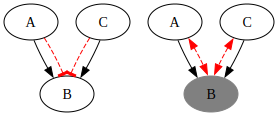

In [487]:
g = gr.Digraph()

g.node("A","A")
g.node("B","B")
g.node("C","C")

g.edge("C", "B", color='red', style='dashed', arrowhead='tee')
g.edge("A", "B")
g.edge("C", "B")
g.edge("A", "B", color='red', style='dashed', arrowhead='tee')

g.node("A2","A")
g.node("B2","B", color='gray', style='filled')
g.node("C2","C")

g.edge("C2", "B2", dir='both', color='red', style='dashed')
g.edge("A2", "B2")
g.edge("C2", "B2")
g.edge("A2", "B2", dir='both', color='red', style='dashed')

g

### Dependence Flow Rules
Using these structures, we can deem if two nodes $A$ and $B$ are dependent by checking **if an unblocked path exists between $A$ and $B$**. This can be done by combining the rules we have seen above, which are also summarized in the following figure:

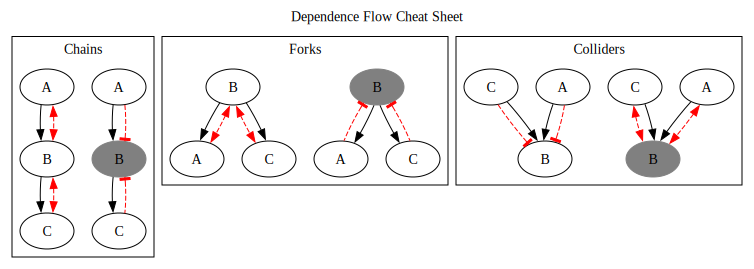

In [488]:
gg = gr.Digraph('G')

gg.attr(label='Dependence Flow Cheat Sheet', labelloc='t')


with gg.subgraph(name='cluster_A') as g:
    g.attr(label='Chains')

    g.node("3A2","A")
    g.node("3B2","B", color='gray', style='filled')
    g.node("3C2","C")
    g.edge("3A2", "3B2")
    g.edge("3B2", "3C2")
    g.edge("3A2", "3B2",arrowhead='tee', color='red', style='dashed')
    g.edge("3B2", "3C2", dir='back',arrowtail='tee',color='red', style='dashed')

    g.node("3A","A")
    g.node("3B","B")
    g.node("3C","C")
    g.edge("3A", "3B")
    g.edge("3B", "3C")
    g.edge("3A", "3B", dir='both', color='red', style='dashed')
    g.edge("3B", "3C", dir='both', color='red', style='dashed')

with gg.subgraph(name='cluster_C') as g:
    g.attr(label='Forks')
    g.node("2A2","A")
    g.node("2B2","B", color='gray', style='filled')
    g.node("2C2","C")

    g.edge("2B2", "2A2",arrowtail='tee', dir='back', color='red', style='dashed')
    g.edge("2B2", "2A2")
    g.edge("2B2", "2C2")
    g.edge("2B2", "2C2", dir='back',arrowtail='tee',color='red', style='dashed')

    g.node("2A","A")
    g.node("2B","B")
    g.node("2C","C")

    g.edge("2B", "2C", dir='both', color='red', style='dashed')
    g.edge("2B", "2A")
    g.edge("2B", "2C")
    g.edge("2B", "2A", dir='both', color='red', style='dashed')

with gg.subgraph(name='cluster_B') as g:
    g.attr(label='Colliders')

    g.node("A2","A")
    g.node("B2","B", color='gray', style='filled')
    g.node("C2","C")

    g.edge("C2", "B2", dir='both', color='red', style='dashed')
    g.edge("A2", "B2")
    g.edge("C2", "B2")
    g.edge("A2", "B2", dir='both', color='red', style='dashed')
    
    g.node("A","A")
    g.node("B","B")
    g.node("C","C")

    g.edge("C", "B", color='red', style='dashed', arrowhead='tee')
    g.edge("A", "B")
    g.edge("C", "B")
    g.edge("A", "B", color='red', style='dashed', arrowhead='tee')

gg

The cheat sheet above is replicated from [here](http://ai.stanford.edu/~paskin/gm-short-course/lec2.pdf) and [here](https://matheusfacure.github.io/python-causality-handbook/04-Graphical-Causal-Models.html). You can find more information at those URLs.

We will say that a path between $A$ and $B$ is blocked if:

> * It contains a non-collider that **has been conditioned on**;
> * It contains a collider that **has not been conditioned on** and has no descendants that have been conditioned on.

Let us see an example from [here](https://matheusfacure.github.io/python-causality-handbook/04-Graphical-Causal-Models.html) and let us try to answer some questions:

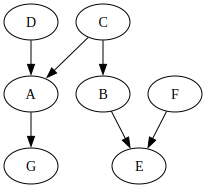

In [495]:
g = gr.Digraph()
g.edge("C", "A")
g.edge("C", "B")
g.edge("D", "A")
g.edge("B", "E")
g.edge("F", "E")
g.edge("A", "G")

g

#### Question 1: is $D \perp C$?
The $D \to A \leftarrow C$ structure is a **collider**. We know that, when we do not condition on the collider, the collider blocks dependence, so we can say that:

$$D \perp C$$

#### Question 2: is $D \perp C | A$?

We have the following graph:

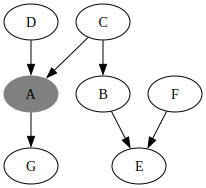

In [496]:
g = gr.Digraph()
g.edge("C", "A")
g.edge("C", "B")
g.edge("D", "A")
g.edge("B", "E")
g.edge("F", "E")
g.edge("A", "G")

g.node('A', style='filled', color='gray')
g

We are conditioning on the collider, hence unblocking the dependence, so we can say:

$$D \not\perp C | A $$

#### Question 3: is $D \perp C | G$?

We now have this graph:

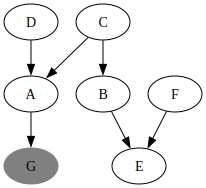

In [497]:
g = gr.Digraph()
g.edge("C", "A")
g.edge("C", "B")
g.edge("D", "A")
g.edge("B", "E")
g.edge("F", "E")
g.edge("A", "G")

g.node('G', style='filled', color='gray')
g

We are not conditioning on the collider $A$, but we are conditioning on a descendant of the collider $A$. We can see this descendant as **a proxy for $A$**, so conditioning on it is similar to conditioning on $A$. For instance, consider this graph:

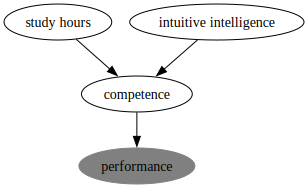

In [506]:
g = gr.Digraph()
g.node('C', 'study hours')
g.node('D', 'intuitive intelligence')
g.node('A', 'competence')
g.edge("C", "A")
g.edge("D", "A")
g.edge("A", "G")

g.node('G', 'performance', style='filled', color='gray')
g

In the example above, `competence` indicates how competent the student is in the considered subjects. If the student is highly competent, we expect them to achieve good performance, hence the cause-effect relationship.

Even if we are not conditioning on `competence`, we are conditioning on a proxy for competence, i.e., `performance`. When we condition on this node, `study hours` and `intuitive` intelligence will appear as dependent for the "explaining away" effect.

Also, recall that we said that a path between $A$ and $B$ is blocked if:

> * It contains a non-collider that **has been conditioned on**;
> * It contains a collider that **has not been conditioned on** and has no descendants that have been conditioned on.

In our case, we are conditioning on a descendant of the collider, hence `study hours` and `intuitive intelligence` will be dependent. In our general graph, we can say that:

$$D \not\perp C | G$$

#### Question 4: is $A \perp F$?

We can illustrate the dependence flow with red dashed arrows as follows:

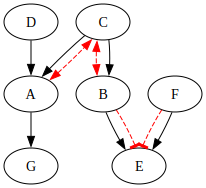

In [516]:
g = gr.Digraph()
g.edge("C", "A")
g.edge("C", "B", style='dashed', color='red', dir='both')
g.edge("C", "B")

g.edge("D", "A")

g.edge("B", "E")
g.edge("B", "E", style='dashed', color='red', dir='forward', arrowhead='tee')

g.edge("F", "E", style='dashed', color='red', dir='forward', arrowhead='tee')
g.edge("F", "E")

g.edge("A", "G")

g.edge("A", "C", style='dashed', color='red', dir='both')


g

As we can see, $A$ and $B$ are dependent, but, due to the collider $E$, $B$ is independent from $F$, so, the path between $A$ and $F$ is blocked by the collider $E$ which has not been conditioned on. We can say:

$$A \perp F$$

#### Question 5: is $A \perp F | E$?
We now have this dependence flow:

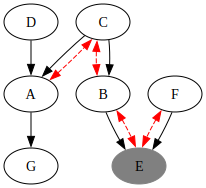

In [518]:
g = gr.Digraph()
g.edge("C", "A")
g.edge("C", "B", style='dashed', color='red', dir='both')
g.edge("C", "B")

g.edge("D", "A")

g.edge("B", "E")
g.edge("B", "E", style='dashed', color='red', dir='both')

g.edge("F", "E", style='dashed', color='red', dir='both')
g.edge("F", "E")

g.edge("A", "G")

g.edge("A", "C", style='dashed', color='red', dir='both')

g.node("E", style='filled', color='gray')


g

Conditioning on $E$ has opened the path between $B$ and $F$ and now the path between $A$ and $F$ is unblocked. In other words, **the path between $A$ and $F$ contains a collider which has been conditioned on**, to the path is unblocked. Since the path is unblocked, the two variables are not independent:

$$A \not\perp F | E$$

#### Question 6: is $A \perp F | E, C$?

Let us see the dependence flow in this case:

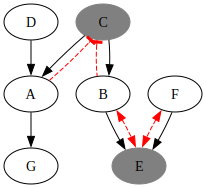

In [526]:
g = gr.Digraph()
g.edge("C", "A")
g.edge("C", "B", style='dashed', color='red', dir='back', arrowtail='tee')
g.edge("C", "B")

g.edge("D", "A")

g.edge("B", "E")
g.edge("B", "E", style='dashed', color='red', dir='both')

g.edge("F", "E", style='dashed', color='red', dir='both')
g.edge("F", "E")

g.edge("A", "G")

g.edge("A", "C", style='dashed', color='red', dir='forward', arrowhead='tee')

g.node("E", style='filled', color='gray')
g.node("C", style='filled', color='gray')


g

Since $C$ is a non collider node, conditioning on it blocks the path between $A$ and $B$. Conditioning on $E$ unblocks the path between $B$ and $F$, but a block remains in the path between $A$ and $F$, hence the two variables are independent:

$$A \perp F | E, C$$

## Using Graphical Causal Models to Diagnose Bias
We will now see how using graphical causal models allows to diagnose bias and understand which variables we should condition on and which we should not when trying to measure a causal effect through correlation. We will see that we have two main sources of bias: **confounding bias** and **selection bias**.

### Confounding Bias
Confounding bias happens when **the treatment and the effect have a common cause**. Let us consider the following example, which we already saw previously:

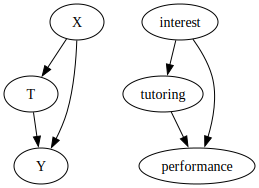

In [1]:
import graphviz as gr

g = gr.Digraph()
g.edge("X", "T")
g.edge("X", "Y")
g.edge("T", "Y")

g.edge("interest", "tutoring")
g.edge("interest", "performance")
g.edge("tutoring", "performance")

g

Here, the outcome $Y$ is `performance`, which is caused by both the treatment $T$ (`tutoring`) and another common cause $X$ (`interest`). The common cause $X$ is called **a counfounder** because it mixes ups the effects of `tutoring` on `performance` and `interest` on `performance`. Indeed, if we measure the correlation between `tutoring` and `performance`, we obtain a large number, but we do not know if this is due to the common cause `interest`. Maybe, people choose tutoring because they are interested and obtain good performance because they are interested as well.

If we want to be able to measure the **direct effect between the treatment and the outcome**, we need to **close the backdoor path between $Y$ and $T$**. This is done by **conditioning on the common cause**:

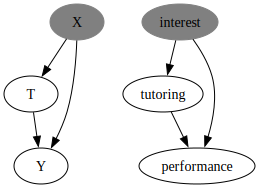

In [5]:
import graphviz as gr

g = gr.Digraph()
g.edge("X", "T")
g.edge("X", "Y")
g.edge("T", "Y")

g.node("X", style='filled', color='gray')

g.edge("interest", "tutoring")
g.edge("interest", "performance")
g.edge("tutoring", "performance")
g.node("interest", style='filled', color='gray')

g

Note that this corresponds to comparing subjects with the same level of interest. In this case, we will observe the direct effect of `tutoring` on `performance`, since all students in the considered ground have the same level of `interest` (so any association between `tutoring` and `performance` is given by the  causal effect). By conditioning on $X$, we obtain:

$$Y(0) \perp Y(1) | T, X$$

### Multiple Common Causes and Unmeasurable Variables (Optional)
Note that we can also have multiple common causes. Let us consider the following example:

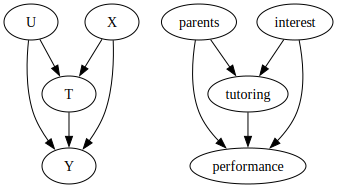

In [17]:
import graphviz as gr

g = gr.Digraph()
g.edge("U", "Y")
g.edge("U", "T")
g.edge("X", "T")
g.edge("X", "Y")
g.edge("T", "Y")


#g.node("X", style='filled', color='gray')

g.edge("parents", "performance")
g.edge("parents", "tutoring")
g.edge("interest", "tutoring")
g.edge("interest", "performance")
g.edge("tutoring", "performance")

#g.node("interest", style='filled', color='gray')

g

We added a new variable `parents`, because we assume that parents may motivate their kids to study more and obtain good performance and to choose tutoring programs to improve their grades. **This is another confounder**, which is going to affect the correlation between `tutoring` and `performance`. Ideally, we wound need to **condition on both `parents` and `interest` to close all backdoor paths between `tutoring` and `performance`**. We denoted `parents` as $U$, because, as we defined it, this variable is **unmeasurable**. We are hypothesizing that parents will influence students, but we do not have a direct way to check this. Something we can do is to measure **how many hours parents dedicate to their kids in a one-to-one study sessions**. We can do so by introducing a new variable:

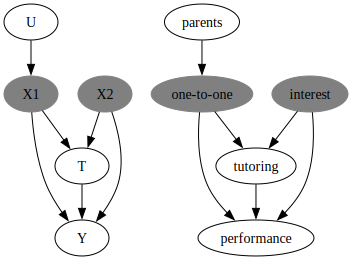

In [21]:
import graphviz as gr

g = gr.Digraph()
g.edge("U", "X1")
g.edge("X1", "Y")
g.edge("X1", "T")
g.edge("X2", "T")
g.edge("X2", "Y")
g.edge("T", "Y")


g.node("X1", style='filled', color='gray')
g.node("X2", style='filled', color='gray')

g.edge("parents", "one-to-one")
g.edge("one-to-one", "performance")
g.edge("one-to-one", "tutoring")
g.edge("interest", "tutoring")
g.edge("interest", "performance")
g.edge("tutoring", "performance")

g.node("interest", style='filled', color='gray')
g.node("one-to-one", style='filled', color='gray')

g

While we cannot not directly condition on `parents` ($U$), we can now condition on the direct effect of `parents`, `one-to-one`, which is measurable ($X1$). We now have to condition on all common causes, $X1$ and $X2$, to obtain:

$$Y(0) \perp Y(1) | T, X1, X2$$

#### Surrogate Confounders (Optional)
In some cases, unmeasurable variables do not have a measurable direct effect. Let us consider the following example:

> We are interested in studying if a given habit (e.g., smoking) can have a causal effect on the development of a given disease. We observe a strong correlation, i.e., subject how have the habit develop the disease more likely. However, someone argues that a gene may exists that causes both the habit and the disease. For instance, people may have the "smoking gene" which "makes them like smoking" and at the same time makes it more likely for them to get the disease.

The assumption will lead us to the following causal graph:

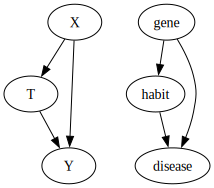

In [22]:
import graphviz as gr

g = gr.Digraph()
g.edge("X", "T")
g.edge("X", "Y")
g.edge("T", "Y")

#g.node("X", style='filled', color='gray')

g.edge("gene", "habit")
g.edge("habit", "disease")
g.edge("gene", "disease")

#g.node("interest", style='filled', color='gray')

g

We have confounding bias and we should condition on `gene` to remove bias. However, we are not sure if the gene actually exists and we only have a theory that the presence of the gene causes some symptoms `symptom1` and `symptom2`. We may also expect that if a subject has the "smoking gene", then also their relatives do so. We hence introduce a proxy variable `familiarity` which counts the number of relatives that we expect to have the gene (because we measured the symptoms or the likelihood of the disease). We obtain the following graph:

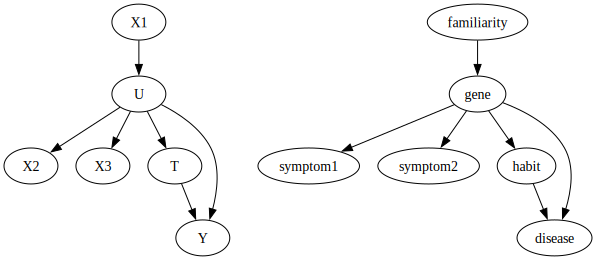

In [29]:
import graphviz as gr

g = gr.Digraph()
g.edge("X1", "U")
g.edge("U", "X2")
g.edge("U", "X3")
g.edge("U", "T")
g.edge("U", "Y")
g.edge("T", "Y")

#g.node("X", style='filled', color='gray')

g.edge("familiarity", "gene")

g.edge("gene", "symptom1")
g.edge("gene", "symptom2")
g.edge("gene", "habit")
g.edge("habit", "disease")
g.edge("gene", "disease")

#g.node("interest", style='filled', color='gray')

g

**We should close all backdoor paths between $T$ and $Y$ by conditioning on $U$**, but since we cannot condition on the unobserved variable `gene`, **the best we can do is to condition on the surrogate confounders $X1$, $X2$, and $X3$**:

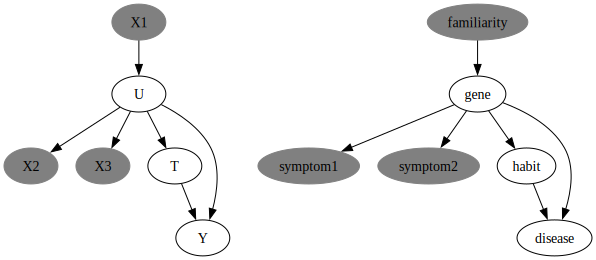

In [28]:
import graphviz as gr

g = gr.Digraph()
g.edge("X1", "U")
g.edge("U", "X2")
g.edge("U", "X3")
g.edge("U", "T")
g.edge("U", "Y")
g.edge("T", "Y")

g.node("X1", style='filled', color='gray')
g.node("X2", style='filled', color='gray')
g.node("X3", style='filled', color='gray')

g.edge("familiarity", "gene")

g.edge("gene", "symptom1")
g.edge("gene", "symptom2")
g.edge("gene", "habit")
g.edge("habit", "disease")
g.edge("gene", "disease")

g.node("symptom1", style='filled', color='gray')
g.node("symptom2", style='filled', color='gray')
g.node("familiarity", style='filled', color='gray')

g

**This will not close the backdoor path between $T$ and $Y$, as these variables are not in the backdoor path, but it will help reducing the bias**.

### Selection Bias
While confounding bias happens when we do not condition on a common cause, selection bias happens when **we control for too many variables**. While one may think that it is a good idea to control on any variable "just in case", this is not true in general and can lead to **selection bias**. 

#### Controlling For a Common Effect
Let us consider the following example in which we want to measure the causal effect of `intuitive intelligence` on `performance`:

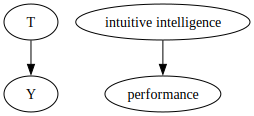

In [38]:
g = gr.Digraph()
g.edge("T", "Y")

#g.node("B", "B", style='filled', color='gray')

g.edge("intuitive intelligence", "performance")

#g.node("performance", "performance", style='filled', color='gray')

g

In our data, we also have a score of a test on problem solving. **"Just to be sure", we condition on `problem solving`**:

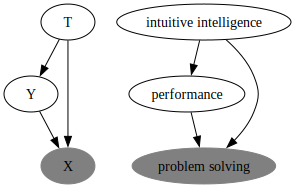

In [40]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("T", "X")
g.edge("Y", "X")

g.node("X", style='filled', color='gray')

g.edge("intuitive intelligence", "performance")
g.edge("intuitive intelligence", "problem solving")
g.edge("performance", "problem solving")

g.node("problem solving",style='filled', color='gray')

g

The problem is that `problem solving` is a common effect of `performance` and `intuitive intelligence`. By conditioning on the common effect, we are introducing a form of bias. Indeed, **if we look at people with good problem solving abilities, we are probably looking at people with either good performance or good intuitive intelligence**. Indeed, knowing that the person has good performance **explains away whether they have intuitive intelligence**, hence showing a correlation which does not represent a causal effect. **By conditioning on the common cause, we opened a backdoor path between $Y$ and $T$ which affects the perceived association between treatment and outcome**.

Note that the same is true if we condition on a descendant of the common cause. For instance:

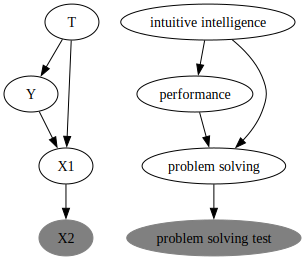

In [43]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("T", "X1")
g.edge("Y", "X1")
g.edge("X1", "X2")

g.node("X2", style='filled', color='gray')

g.edge("intuitive intelligence", "performance")
g.edge("intuitive intelligence", "problem solving")
g.edge("performance", "problem solving")
g.edge("problem solving", "problem solving test")

g.node("problem solving test",style='filled', color='gray')

g

#### Controlling on a Mediator
Another case of selection bias, arising from cases in which we control for variables we should not control on, is given by the case in which we control on a mediator of the treatment and the outcome. Let us consider this example:

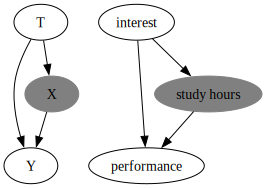

In [48]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("T", "X")
g.edge("X", "Y")

g.node("X", style='filled', color='gray')

g.edge("interest", "performance")
g.edge("interest", "study hours")
g.edge("study hours", "performance")

g.node("study hours",style='filled', color='gray')

g

We want to assess the effect of `interest` on performance. Let's say we could randomize interest (for instance, we selected students with different levels of interest randomly across different schools). **"Just to be sure", we condition on `study hours`**. Conditioning on the mediator closes a path between `interest` and `performance`, hence reducing the measured effect between `interest` and `performance`.

**Indeed, while we expect that interested students will study more and obtain better performance, by observing only people who study a lot, `interest` and `performance` may seem to be little correlated. Indeed, even people with little interest will obtain good performance if they study for long hours.**

#### Main Sources of Bias
To summarize, the main sources of bias are three:

* **Confounders**: we should control on the common cause;
* **Selection Bias - Common Effect**: we should not control on the common effect;
* **Selection Bias - Mediator**: we should not control on the mediator.

These are shown in the graph below:

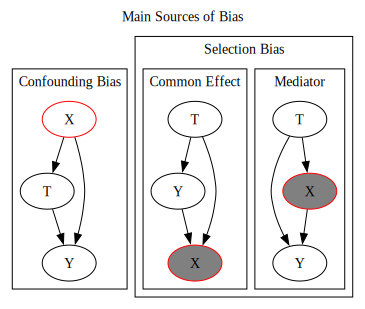

In [100]:
gg = gr.Digraph('G')

gg.attr(label='Main Sources of Bias', labelloc='t')


with gg.subgraph(name='cluster_A') as g:
    g.attr(label='Confounding Bias')

    g.edge("X", "T")
    g.edge("T", "Y")
    g.edge("X", "Y")

    g.node("X", color='red')
    

with gg.subgraph(name='cluster_B') as g:
    g.attr(label='Selection Bias')

    with g.subgraph(name='cluster_B2') as ggg:
        ggg.attr(label='Mediator')

        ggg.node("T3", "T")
        ggg.node("Y3", "Y")
        ggg.node("X3", "X")
        
        ggg.edge("X3", "Y3")
        ggg.edge("T3", "X3")
        ggg.edge("T3", "Y3")

        ggg.node('X3', style='filled', color="red", fillcolor='gray')

    with g.subgraph(name='cluster_B1') as ggg:
        ggg.attr(label='Common Effect')

        ggg.node("T2", "T")
        ggg.node("Y2", "Y")
        ggg.node("X2", "X")

        ggg.edge("T2", "Y2")
        ggg.edge("Y2", "X2")
        ggg.edge("T2", "X2")

        ggg.node('X2', style='filled', color="red", fillcolor='gray')
gg

In the figure above, we mark in red the nodes that are not conditioned on, but should be conditioned on, and the nodes that are conditioned on, but should not be conditioned on.

## Linear Regression for Causal Analysis
We have seen how to choose a suitable set of variables to control for when we aim to establish a cause-effect relationship. When we said "we control for $X$", we implied that we can divide the data in groups and measure association within each group, to then aggregate results and obtain an average effect.

In this section, we will see how we can automate this process with **linear regression**. Let us consider our previous example in which we wanted to measure the causal effect of `tutoring` on `performance`, when we know that `interest` can be a confounder:

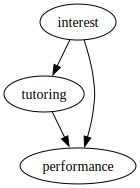

In [336]:
import graphviz as gr

g = gr.Digraph()

g.edge("interest", "tutoring")
g.edge("interest", "performance")
g.edge("tutoring", "performance")

g


This is the data:

In [380]:
students = students3
students

,tutoring,performance,interest
0,0,76.432447,2.0
1,1,91.550461,5.0
2,1,85.107378,4.0
3,0,69.981030,3.0
4,1,70.111151,2.0
...,...,...,...
195,0,68.477160,2.0
196,0,87.783594,4.0
197,1,88.220111,5.0
198,1,93.399423,5.0


Recall that in this case the assignment is not random, so we expect `interest` to influence both `tutoring` and `performance`. If we ignore this bias, we can compute the average difference in the effect of the treated and untreated:

$$E[performance|tutoring=1] - E[performance|tutoring=0]$$

We can do this in computational terms as follows:

In [381]:
students[tutoring==1]['performance'].mean()-students[tutoring==0]['performance'].mean()

6.826889013112677

Another relevant value to compute is the average performance of the untreated:

In [385]:
students[students['tutoring']==0]['performance'].mean()

72.92912990981884

We can see how these values are **automatically computed within a linear regressor** of the kind:

$$performance = \beta_0 + \beta_1 tutoring$$

These are the coefficients after fitting:

In [384]:
ols("performance ~ tutoring ", students3).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,72.9291,1.199,60.832,0.000,70.565,75.293
tutoring,6.8269,1.671,4.087,0.000,3.533,10.121


Coherently with the interpretation we previously gave of linear regression, we obtain estimates for those two values:
* `intercept`: is the average performance of the untreated, i.e., the value of `performance` we expect to see in average when `tutoring=0`;
* `tutoring`: is the increment of `performance` we expect to see in average when we observe an increment of one unit in `tutoring` (i.e., when passing from `tutoring=0` to `tutoring=1`). This is the average difference of `performance` when comparing the treated `tutoring=1` and the untreated `tutoring=0`.

Also, when we use a linear regressor, we get confidence intervals and the results of statistical tests "for free".

If we look at the result above, **there is non-zero correlation between `performance` and `tutoring`**. Indeed, the coefficient of `tutoring` allows us to observe that **students who enroll in the `tutoring` programme, increase their average `performance` by $6.8269$ points** (remember that performance lies in the $[0,100]$ range). However, we also know that this result is biased due to the confounder `interest`. To remove this bias, we should condition on `interest`:

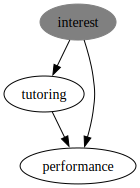

In [386]:
import graphviz as gr

g = gr.Digraph()

g.edge("interest", "tutoring")
g.edge("interest", "performance")
g.edge("tutoring", "performance")


g.node('interest', style='filled', color='gray')
g

We note that one way to **control for a variable is to include it among the independent variables in the linear regressor**, i.e., fitting a model like this:

$$performance = \beta_0 + \beta_1 tutoring + \beta_2 interest$$

The result is as follows:

In [388]:
ols("performance ~ tutoring + interest", students3).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,54.1697,1.296,41.804,0.000,51.614,56.725
tutoring,-0.9516,1.129,-0.843,0.400,-3.178,1.275
interest,7.8097,0.441,17.711,0.000,6.940,8.679


We note that, after adding this variable, the values of the coefficients changed substantially. **We are in particular interested in the coefficient of `tutoring`, which is measuring the correlation between `tutoring` and `performance`**. We note that we can now interpret this value as follows:

> $\beta_1$ (coefficient of `tutoring`) is the increment we expect to observe in `performance` when `tutoring` passes from $0$ to $1$ **and `interest` is held constant**.

This last bit is the fundamental one: **by including the `interest` variable, we are effectively controlling for `interest`**. Indeed, the coefficient of `tutoring` now virtually looks at a subset of the data in which `interest` is constant. This is in practice the average effect of `tutoring` when comparing groups of data with constant `interest`.

Hence, **even if we cannot physically perform a random assignment, linear regression allows us to control for variables, hence enabling the analysis of observational data**. This is fundamental, as it is not in always feasible to perform random tests.

Getting back to our result above, we note that the coefficient of `tutoring` has a p-value of $0.4$. This means that, while a value different from zero has been computed for it, the hypothesis test is telling us that **we do not have enough elements to say that this value actually is different from zero**. Hence, we can conclude that `tutoring` does not have a statistically significant impact on `performance`.

Note that, **if we compute a linear regressor on the randomized set (i.e., the one in which we pretended we could perform random assignment)**

$$performance = \beta_0 + \beta_1 tutoring$$

we obtain these results:

In [393]:
ols('performance ~ tutoring', students2).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,77.5258,1.281,60.542,0.000,75.001,80.051
tutoring,-1.9648,1.735,-1.133,0.259,-5.385,1.456


Coherently with the conclusions made with observational data, there is not a significant relationship between `tutoring` and `performance`.

### Example on the LUCAS Dataset
We will see some examples on the LUCAS dataset, which can be found here:

https://www.causality.inf.ethz.ch/data/LUCAS.html

LUCAS is an **artificial dataset** in which data has been generated drawing values from known distribution to emulate a causal phenomenon. Besides the data, the authors propose the **following true causal graph** (which reflects the way data has been generated):

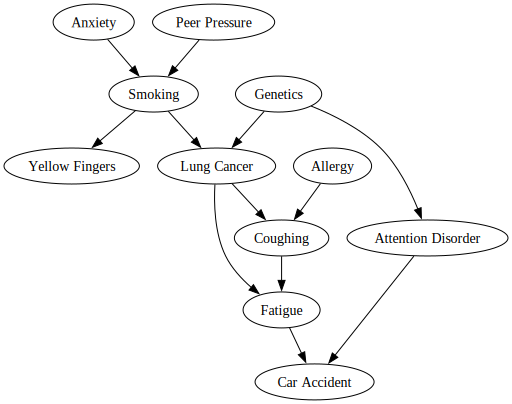

In [394]:
g = gr.Digraph()
g.edge("Anxiety", "Smoking")
g.edge("Peer Pressure", "Smoking")
g.edge("Smoking", "Yellow Fingers")
g.edge("Smoking", "Lung Cancer")
g.edge("Genetics", "Lung Cancer")
g.edge("Genetics", "Attention Disorder")
g.edge("Allergy", "Coughing")
g.edge("Coughing", "Fatigue")
g.edge("Lung Cancer", "Coughing")
g.edge("Lung Cancer", "Fatigue")
g.edge("Attention Disorder", "Car Accident")
g.edge("Fatigue", "Car Accident")

g

Let us have a look at the data:

In [411]:
lucas=pd.read_csv('http://www.causality.inf.ethz.ch/data/lucas0_train.csv')
lucas

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


#### Does `Smoking` causes `Car Accident`?
We will try to answer the question as to whether there is a causal effect between `Smoking` and `Car Accident`. We can start by fitting a logistic regressor:

$$P(Car Accident|Smoking) = \sigma(\beta_0 + \beta_1 Smoking)$$

We need to fit a logistic regressor because the dependent variable is binary (all variables are binary). This is the result:

In [412]:
logit('Car_Accident ~ Smoking', lucas).fit().summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.588796
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.7668,0.097,7.939,0.000,0.578,0.956
Smoking,0.2596,0.113,2.299,0.022,0.038,0.481


From the observation above, it seems that `Smoking` is positively associated with `Car Accident`. Since $e^{0.2596} \approx 1.3$, we can say that smoking is associated by an increase of $+30%$ in the odds of having a car accident. But, can we say that this is a causal effect? I.e., can we say that **smoking causes an increment in the odd of car accident**?

We know that there might be some bias. To check for that, let us consider the causal graph again, and let us highlight all dependence paths from the `Smoking` node to the `Car Accident` node. These represent all the different ways in which the two variables can be correlated.

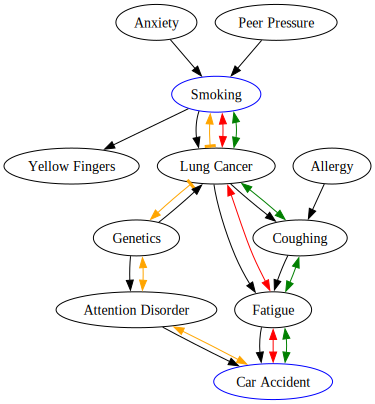

In [413]:
g = gr.Digraph()
g.edge("Anxiety", "Smoking")
g.edge("Peer Pressure", "Smoking")
g.edge("Smoking", "Yellow Fingers")
g.edge("Smoking", "Lung Cancer")
g.edge("Genetics", "Lung Cancer")
g.edge("Genetics", "Attention Disorder")
g.edge("Allergy", "Coughing")
g.edge("Coughing", "Fatigue")
g.edge("Lung Cancer", "Coughing")
g.edge("Lung Cancer", "Fatigue")
g.edge("Attention Disorder", "Car Accident")
g.edge("Fatigue", "Car Accident")

g.node("Smoking", color='Blue')
g.node("Car Accident", color='Blue')

g.edge("Smoking", "Lung Cancer", color='orange', dir='both', arrowhead='tee')
g.edge("Lung Cancer", "Genetics", color='orange', dir='both', arrowtail='tee')
g.edge("Genetics", "Attention Disorder", color='orange', dir='both')
g.edge("Attention Disorder", "Car Accident", color='orange', dir='both')

g.edge("Smoking", "Lung Cancer", color='red', dir='both')
g.edge("Lung Cancer", "Fatigue", color='red', dir='both')
g.edge("Fatigue", "Car Accident", color='red', dir='both')





g.edge("Smoking", "Lung Cancer", color='green', dir='both')
g.edge("Lung Cancer", "Coughing", color='green', dir='both')
g.edge("Coughing", "Fatigue", color='green', dir='both')
g.edge("Fatigue", "Car Accident", color='green', dir='both')



g

We have three possible paths, highlighted in yellow, red, and green. Arrows indicate whether dependency flows or not. We can see that:
* The yellow path is blocked because there is a collider (`Lung Cancer`) that has not been conditioned on. The collider prevents `Smoking` and `Genetics` from being associated. This blocked path is ok for us. We are trying to see if smoking causes car accident, and, since, `Lung Cancer` does not cause `Genetics`, that path would not be a viable one to check for a causal effect;
* The red and green paths are not blocked. This is not ideal, because now there are two ways `Smoking` could influence `Car Accident`, i.e., directly through `Fatigue` or via `Coughing`. This may lead to a combined effect which is stronger than it is supposed to be.

If we want to estimate a causal effect, we need to block one of the two paths. The most sensible thing to do is to **condition on `Coughing`**, so that now smoking can affect Car Accident only through Lung Cancer and then Fatigue. This is illustrated as follows:

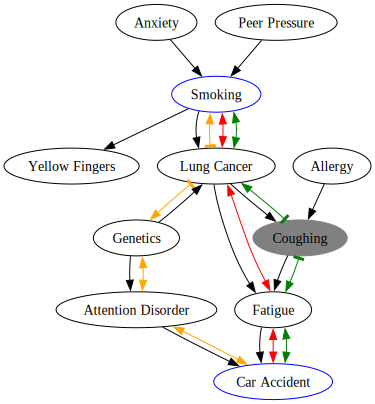

In [414]:
g = gr.Digraph()
g.edge("Anxiety", "Smoking")
g.edge("Peer Pressure", "Smoking")
g.edge("Smoking", "Yellow Fingers")
g.edge("Smoking", "Lung Cancer")
g.edge("Genetics", "Lung Cancer")
g.edge("Genetics", "Attention Disorder")
g.edge("Allergy", "Coughing")
g.edge("Coughing", "Fatigue")
g.edge("Lung Cancer", "Coughing")
g.edge("Lung Cancer", "Fatigue")
g.edge("Attention Disorder", "Car Accident")
g.edge("Fatigue", "Car Accident")

g.node("Smoking", color='Blue')
g.node("Car Accident", color='Blue')

g.edge("Smoking", "Lung Cancer", color='orange', dir='both', arrowhead='tee')
g.edge("Lung Cancer", "Genetics", color='orange', dir='both', arrowtail='tee')
g.edge("Genetics", "Attention Disorder", color='orange', dir='both')
g.edge("Attention Disorder", "Car Accident", color='orange', dir='both')

g.edge("Smoking", "Lung Cancer", color='red', dir='both')
g.edge("Lung Cancer", "Fatigue", color='red', dir='both')
g.edge("Fatigue", "Car Accident", color='red', dir='both')

g.edge("Smoking", "Lung Cancer", color='green', dir='both')
g.edge("Lung Cancer", "Coughing", color='green', dir='both', arrowhead='tee')
g.edge("Coughing", "Fatigue", color='green', dir='both', arrowtail='tee')
g.edge("Fatigue", "Car Accident", color='green', dir='both')

g.node("Coughing", style="filled", color='gray')

g

To condition on `Coughing`, we can fit the following logistic regressor:

$$P(Car Accident|Smoking, Coughing) = \sigma(\beta_0 + \beta_1 Smoking + \beta_2 Coughing)$$

We obtain the following coefficients:

In [417]:
logit('Car_Accident ~ Smoking + Coughing', lucas).fit().summary().tables[1]

Optimization terminated successfully.
         Current function value: 0.569895
         Iterations 5


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.3411,0.108,3.153,0.002,0.129,0.553
Smoking,-0.0130,0.120,-0.108,0.914,-0.248,0.222
Coughing,0.9529,0.109,8.717,0.000,0.739,1.167


We now get a different picture: the p-value of `Smoking` is very large. This means that, once we removed the influence of `Coughing`, the effect of `Smoking` on `Car Accident` is negligible (its coefficient is not significantly different from zero). This suggests that there is no significant causal effect between the two variables.

## References
\[1\] Most of the content of this lecture is based on part of the awesome lecture series "[Causal Inference for The Brave and True](https://matheusfacure.github.io/python-causality-handbook/landing-page.html)" by Matheus Facure Alves.

\[2\] Judea Pearl and Dana Mackenzie. "The Book of Why: The New Science of Cause and Effect". Penguin.
